In [1]:
import pandas as pd
import numpy as np
import shap
import joblib
import plotly.express as px

# Load cleaned data
df = pd.read_csv("../data/car_sales_clean.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

df.head()


,ym,branch,model,units_sold,avg_price,date
0,2008-02,Mercury,Mountaineer,27.609,27.560,2008-02-01
1,2009-10,Mercury,Villager,20.380,22.510,2009-10-01
2,2009-10,Oldsmobile,Alero,80.255,18.270,2009-10-01
3,2011-01,Mercedes-B,SLK,7.998,38.900,2011-01-01
4,2011-01,Nissan,Xterra,54.158,22.799,2011-01-01


In [2]:
# Time features (same as Phase 3)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# One-hot encode branch and model (same settings)
df = pd.get_dummies(df, columns=["branch", "model"], drop_first=True)

# Define feature list exactly as used before
features = [c for c in df.columns if c not in ["units_sold", "date", "ym"]]

X = df[features]
y = df["units_sold"]

len(features), features[:10]


(189,
 ['avg_price',
  'year',
  'month',
  'month_sin',
  'month_cos',
  'branch_Audi',
  'branch_BMW',
  'branch_Buick',
  'branch_Cadillac',
  'branch_Chevrolet'])

In [3]:
bundle = joblib.load("../src/xgb_time_model.joblib")
# If you saved only the model (not a dict), this will still work
xgb = bundle if not isinstance(bundle, dict) else bundle["model"]

xgb


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [4]:
joblib.dump(xgb, "../src/xgb_time_model.joblib")


['../src/xgb_time_model.joblib']

In [10]:
import shap
import numpy as np

shap.initjs()

# Convert dataset to numeric NumPy array
X_np = X.astype(float).values

# Create a masker for numeric arrays
masker = shap.maskers.Independent(X_np, max_samples=100)

# Define model prediction wrapper (must return 1D np array)
def model_predict(data):
    return xgb.predict(pd.DataFrame(data, columns=X.columns))

# Create explainer (model-agnostic but stable)
explainer = shap.Explainer(model_predict, masker)

# Compute SHAP values
shap_values = explainer(X_np)

shap_values


.values =
array([[-2.07872889e-01,  1.76702698e-02, -4.91314265e+00, ...,
         1.64365625e-01, -3.68041992e-03,  0.00000000e+00],
       [-3.19065211e+00, -1.44506184e+00, -8.11778548e-01, ...,
         1.64365768e-01, -3.68038177e-03,  0.00000000e+00],
       [ 3.01945207e+01, -1.98555718e+00,  3.40429070e+00, ...,
         1.64862976e-01, -3.68038177e-03,  0.00000000e+00],
       ...,
       [-1.77794515e+01,  6.63855155e-01,  2.79820050e+01, ...,
         1.64862976e-01, -2.08360672e-03,  0.00000000e+00],
       [-5.25295826e+00,  7.45274889e-01,  2.14113197e+01, ...,
         1.63262177e-01, -5.08766174e-03,  0.00000000e+00],
       [ 2.10873381e+01,  7.91335993e-01,  1.75565546e+01, ...,
         1.63261948e-01, -3.68041992e-03,  0.00000000e+00]],
      shape=(157, 189))

.base_values =
array([49.86548182, 49.86548182, 49.86548182, 49.86548182, 49.86548182,
       49.86548182, 49.86548182, 49.86548182, 49.86548182, 49.86548182,
       49.86548182, 49.86548182, 49.86548182, 49.

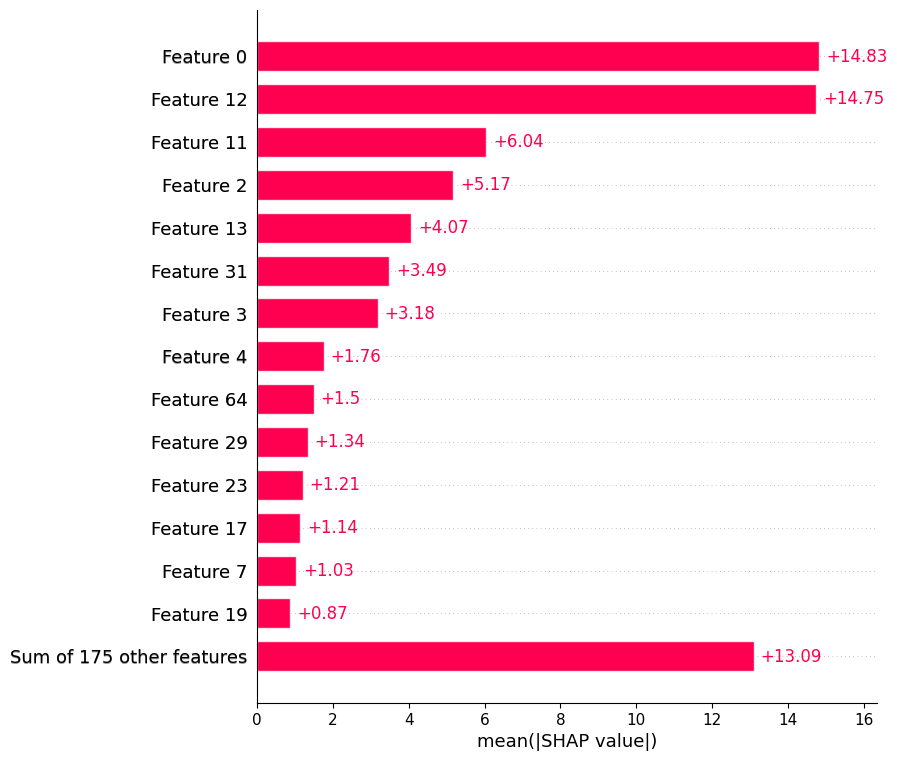

In [19]:
shap.plots.bar(shap_values, max_display=15)

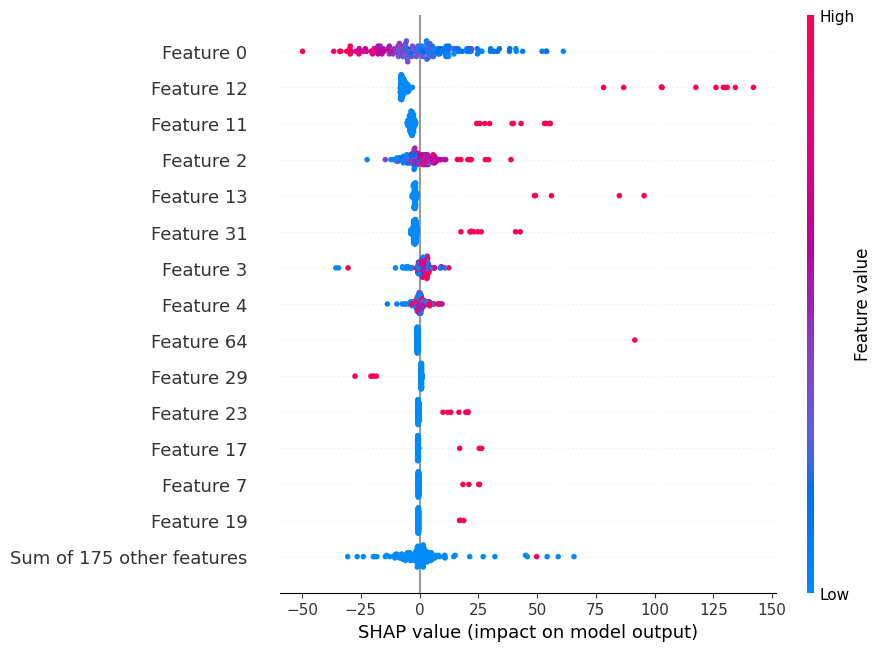

In [12]:
shap.plots.beeswarm(shap_values, max_display=15)


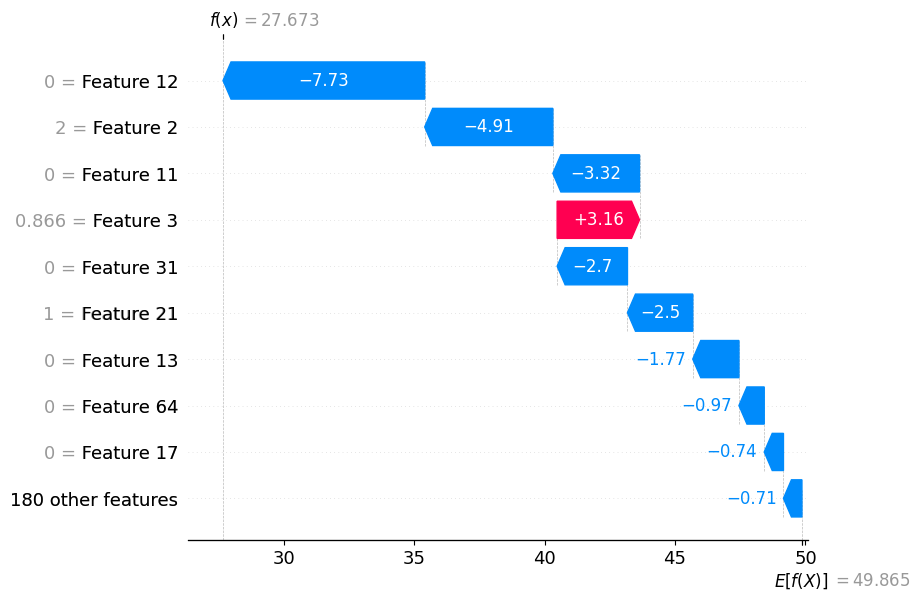

In [13]:
i = 0
shap.waterfall_plot(shap_values[i])
